Модель Random Forest (случайный лес)

Введите ставку Банка России (%):  18
Введите процент инфляции (%):  14


Средняя ошибка кросс-валидации: 65431856253341.27
Среднеквадратичная ошибка (MSE): 37520798994620.45
Коэффициент детерминации (R²): 0.96
Средняя абсолютная ошибка (MAE): 3898821.31


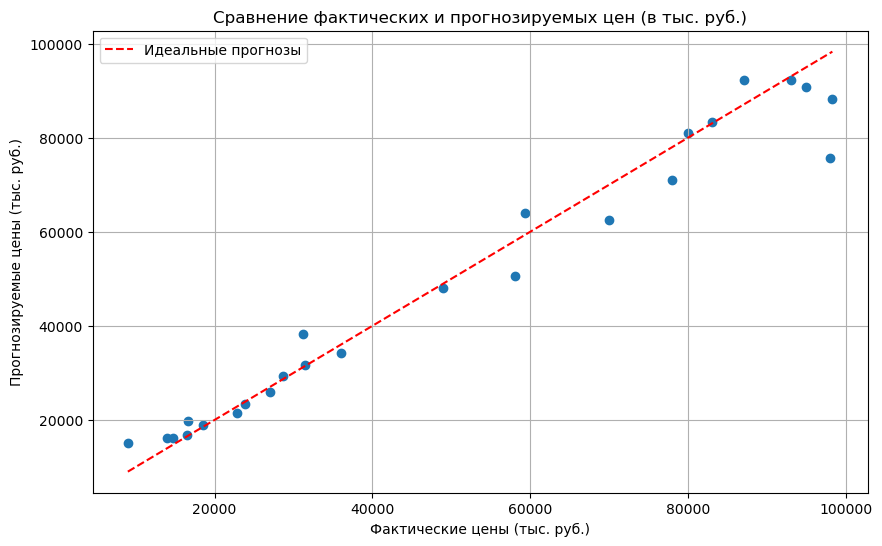

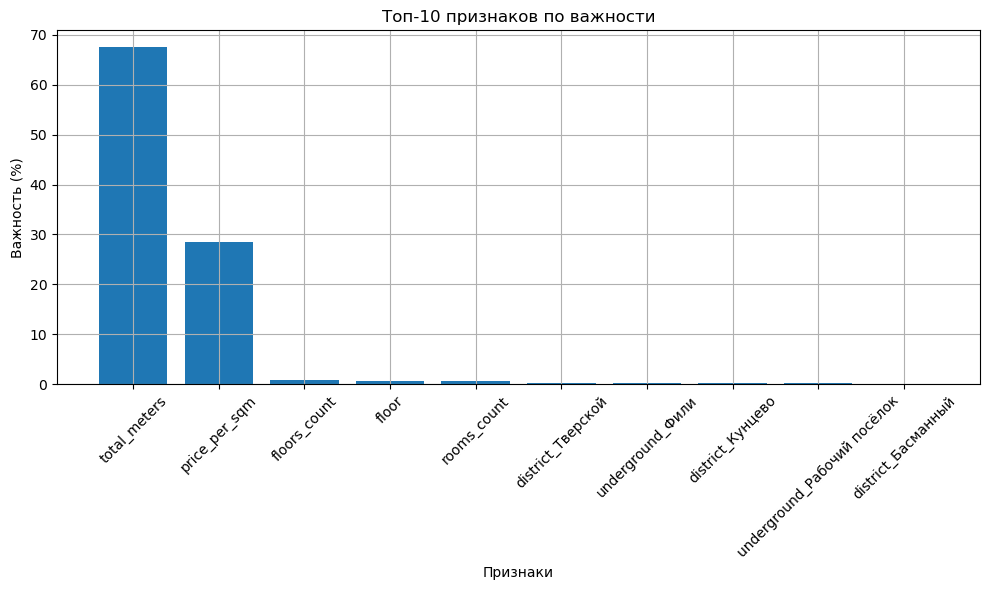

                       Признак  Важность (%)
0                 total_meters     67.527528
1                price_per_sqm     28.550655
2                 floors_count      0.721294
3                        floor      0.649861
4                  rooms_count      0.535418
5            district_Тверской      0.171317
6             underground_Фили      0.156913
7             district_Кунцево      0.119131
8  underground_Рабочий посёлок      0.114831
9           district_Басманный      0.095244


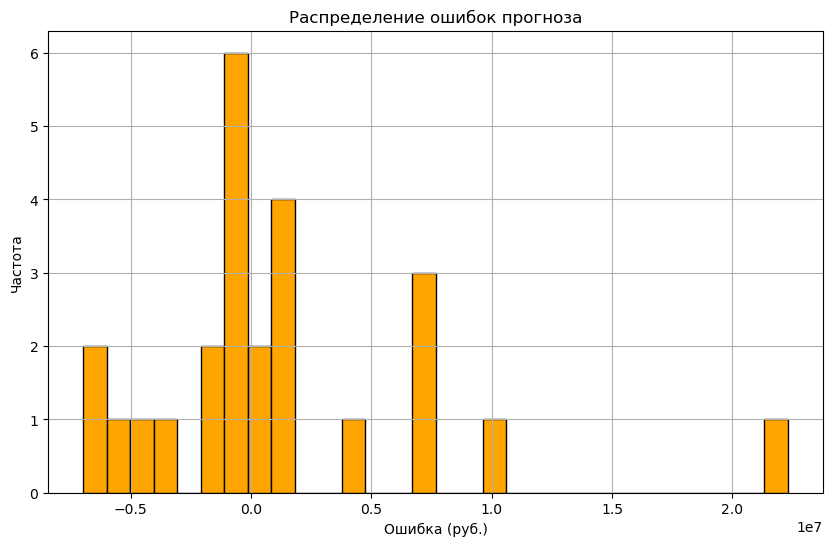

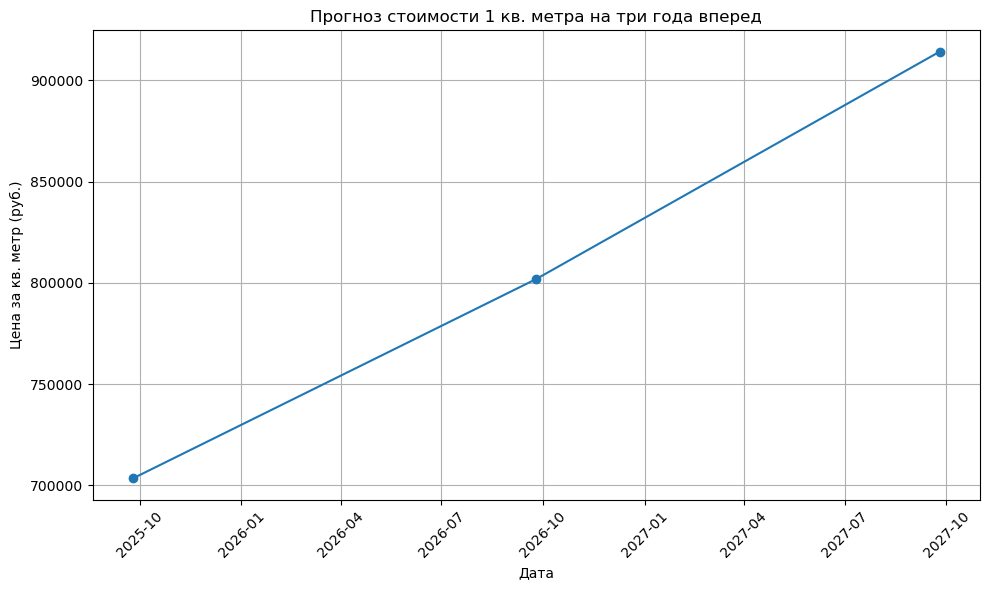

In [10]:
# Модель Random Forest (случайный лес)
# Тестирование на небольшом датафрейме

import os
import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)
data = pd.read_csv(latest_file, sep=',')  # Убедитесь, что разделитель указан правильно

# Создание нового признака: цена за квадратный метр
data['price_per_sqm'] = data['price'] / data['total_meters']

# Ввод пользователем Ставки Банка России
bank_rate = float(input("Введите ставку Банка России (%): "))
inflation_rate = float(input("Введите процент инфляции (%): "))

# Добавление ставки Банка России как нового признака
data['bank_rate'] = bank_rate

# Выбор признаков и целевой переменной (добавлен 'bank_rate')
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price_per_sqm', 'bank_rate']
X = data[features]
y = data['price']

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'price_per_sqm', 'bank_rate']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X_transformed = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Создание модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Кросс-валидация для оценки модели
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Средняя ошибка кросс-валидации: {-cv_scores.mean()}')

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование цен на тестовых данных
predictions = model.predict(X_test)

# Рассчет метрик
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Коэффициент детерминации (R²): {r2:.2f}')
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')

# Визуализация результатов
#plt.figure(figsize=(10, 6))
#plt.scatter(y_test, predictions)
#plt.xlabel('Фактические цены (руб.)')
#plt.ylabel('Прогнозируемые цены (руб.)')
#plt.title('Сравнение фактических и прогнозируемых цен')
#plt.grid()
#plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', label='Идеальные прогнозы')
#plt.legend()
#plt.show()

# Визуализация результатов с изменением размерности данных на "тысячи рублей"
plt.figure(figsize=(10, 6))

# Преобразуем фактические и прогнозируемые данные в тысячи рублей
y_test_thousands = y_test / 1000
predictions_thousands = predictions / 1000

# Построение графика
plt.scatter(y_test_thousands, predictions_thousands)
plt.xlabel('Фактические цены (тыс. руб.)')
plt.ylabel('Прогнозируемые цены (тыс. руб.)')
plt.title('Сравнение фактических и прогнозируемых цен (в тыс. руб.)')
plt.grid()
plt.plot([y_test_thousands.min(), y_test_thousands.max()], 
         [y_test_thousands.min(), y_test_thousands.max()], 
         color='red', linestyle='--', label='Идеальные прогнозы')
plt.legend()
plt.show()


# График важности признаков
importances = model.feature_importances_
feature_names = numerical_features + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Топ 10 признаков по важности
indices = np.argsort(importances)[::-1][:10]
top_importances = importances[indices] / importances.sum() * 100  # В процентах

# График важности признаков
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances, align="center")
plt.xticks(range(len(top_importances)), [feature_names[i] for i in indices], rotation=45)
plt.title("Топ-10 признаков по важности")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.tight_layout()
plt.grid()
plt.show()

# Вывод топ-10 признаков в таблице
top_10_df = pd.DataFrame(zip([feature_names[i] for i in indices], top_importances), columns=['Признак', 'Важность (%)'])
print(top_10_df)

# График распределения ошибок
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.xlabel('Ошибка (руб.)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid()
plt.show()

# Прогноз стоимости 1 кв. метра на 3 года вперед
current_date = datetime.now()  # Используем текущее время как дату загрузки
future_dates = [current_date + timedelta(days=365 * i) for i in range(1, 4)]

# Используем среднюю цену за квадратный метр для прогнозирования
average_price_per_sqm = data['price_per_sqm'].mean()

# Прогнозируемая стоимость с учетом инфляции
future_prices = []
for date in future_dates:
    average_price_per_sqm *= (1 + inflation_rate / 100)  # Увеличиваем цену на процент инфляции
    future_prices.append(average_price_per_sqm)

# Визуализация прогноза стоимости 1 кв. метра
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_prices, marker='o')
plt.title('Прогноз стоимости 1 кв. метра на три года вперед')
plt.xlabel('Дата')
plt.ylabel('Цена за кв. метр (руб.)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Введите ставку Банка России (%):  18
Введите процент инфляции (%):  14


Обнаружено 4 пропусков в целевой переменной 'price'. Удаление строк с пропусками.
Средняя ошибка кросс-валидации: 14173961587234.197
Среднеквадратичная ошибка (MSE): 16256940652085.97
Коэффициент детерминации (R²): 0.97
Средняя абсолютная ошибка (MAE): 2008919.69


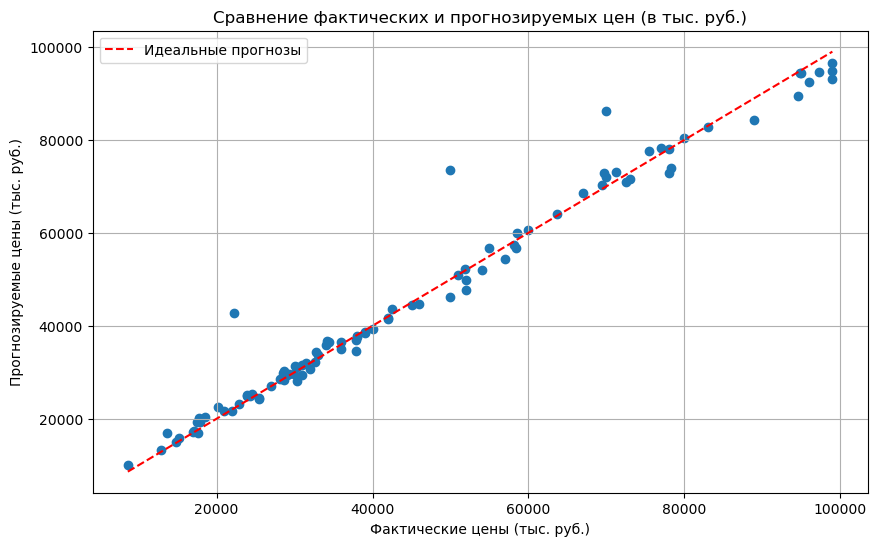

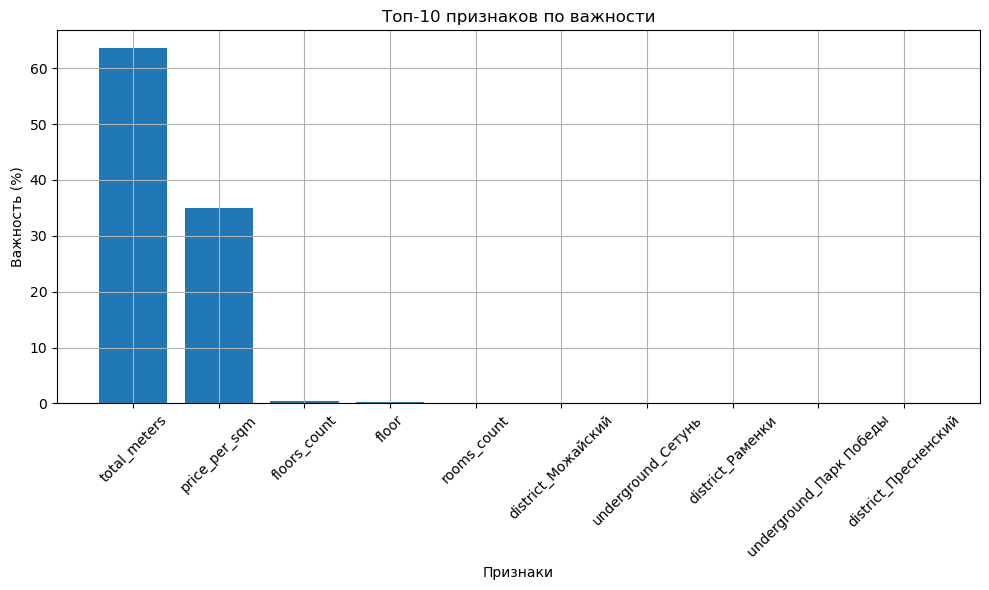

                   Признак  Важность (%)
0             total_meters     63.594769
1            price_per_sqm     34.919812
2             floors_count      0.381576
3                    floor      0.312342
4              rooms_count      0.075517
5       district_Можайский      0.057773
6       underground_Сетунь      0.050929
7         district_Раменки      0.028640
8  underground_Парк Победы      0.027831
9     district_Пресненский      0.022279


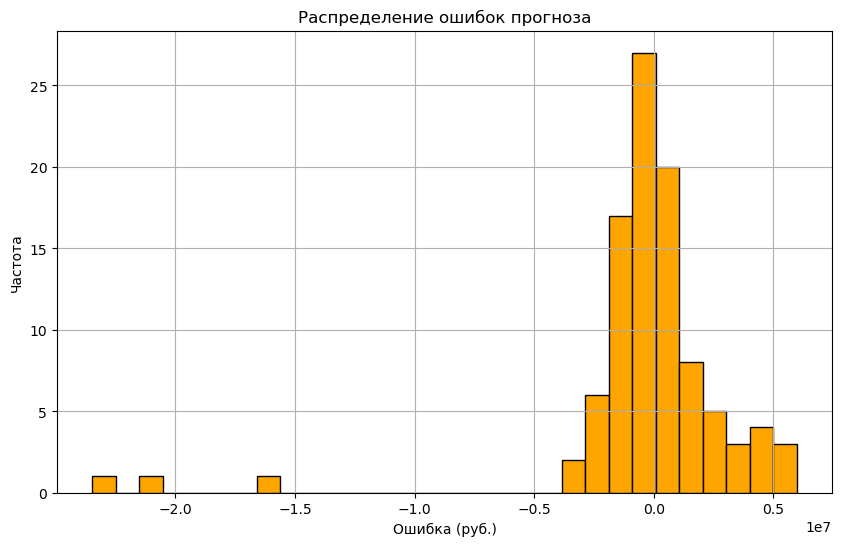

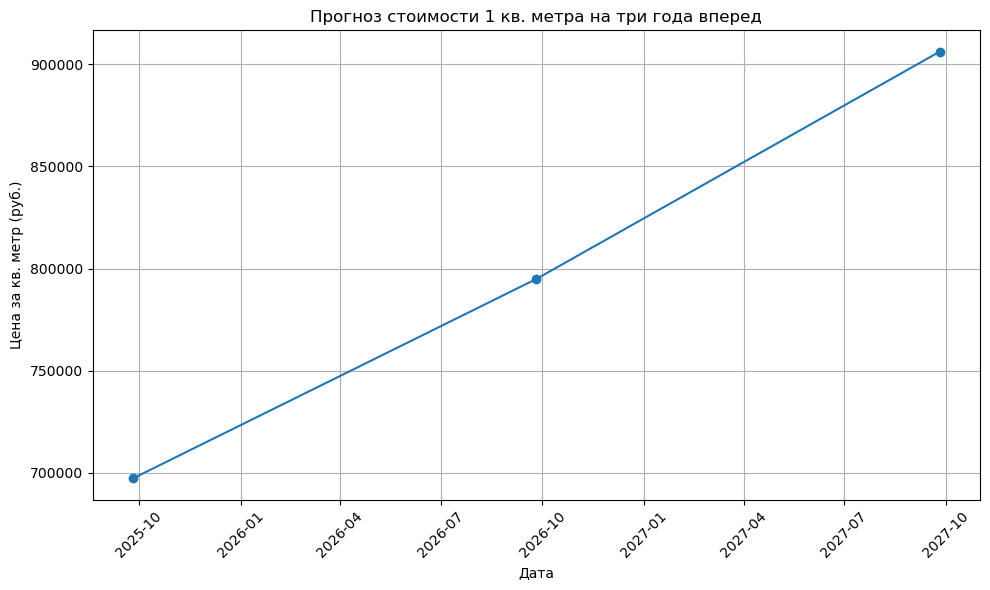

In [6]:


import os
import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Определяем путь к папке Sale
sale_folder = os.path.join(os.getcwd(), 'Sale')

# Находим все CSV файлы с 'sale' в названии в папке Sale
csv_files = glob.glob(os.path.join(sale_folder, '*sale*.csv'))

# Проверка наличия файлов
if not csv_files:
    raise FileNotFoundError("В папке 'Sale' нет CSV файлов с 'sale' в названии.")

# Сортировка файлов по времени создания и выбор последнего
latest_file = max(csv_files, key=os.path.getctime)
data = pd.read_csv(latest_file, sep=',')  # Убедитесь, что разделитель указан правильно

# Создание нового признака: цена за квадратный метр
data['price_per_sqm'] = data['price'] / data['total_meters']

# Ввод пользователем Ставки Банка России
bank_rate = float(input("Введите ставку Банка России (%): "))
inflation_rate = float(input("Введите процент инфляции (%): "))

# Добавление ставки Банка России как нового признака
data['bank_rate'] = bank_rate

# Проверка и удаление строк с пропусками в целевой переменной
if data['price'].isnull().sum() > 0:
    print(f"Обнаружено {data['price'].isnull().sum()} пропусков в целевой переменной 'price'. Удаление строк с пропусками.")
    data = data.dropna(subset=['price'])

# Обновление целевой переменной
y = data['price']

# Выбор признаков и целевой переменной (добавлен 'bank_rate')
features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'district', 'underground', 'price_per_sqm', 'bank_rate']
X = data[features]

# Обработка категориальных признаков
categorical_features = ['district', 'underground']
numerical_features = ['total_meters', 'rooms_count', 'floor', 'floors_count', 'price_per_sqm', 'bank_rate']

# Создание трансформеров для числовых и категориальных данных
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Объединение трансформеров в колонный трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Преобразование данных
X_transformed = preprocessor.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Создание модели случайного леса
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Кросс-валидация для оценки модели
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Средняя ошибка кросс-валидации: {-cv_scores.mean()}')

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование цен на тестовых данных
predictions = model.predict(X_test)

# Рассчет метрик
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Коэффициент детерминации (R²): {r2:.2f}')
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')

# Визуализация результатов
plt.figure(figsize=(10, 6))

# Преобразуем фактические и прогнозируемые данные в тысячи рублей
y_test_thousands = y_test / 1000
predictions_thousands = predictions / 1000

# Построение графика
plt.scatter(y_test_thousands, predictions_thousands)
plt.xlabel('Фактические цены (тыс. руб.)')
plt.ylabel('Прогнозируемые цены (тыс. руб.)')
plt.title('Сравнение фактических и прогнозируемых цен (в тыс. руб.)')
plt.grid()
plt.plot([y_test_thousands.min(), y_test_thousands.max()], 
         [y_test_thousands.min(), y_test_thousands.max()], 
         color='red', linestyle='--', label='Идеальные прогнозы')
plt.legend()
plt.show()

# График важности признаков
importances = model.feature_importances_
feature_names = numerical_features + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))

# Топ 10 признаков по важности
indices = np.argsort(importances)[::-1][:10]
top_importances = importances[indices] / importances.sum() * 100  # В процентах

# График важности признаков
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_importances)), top_importances, align="center")
plt.xticks(range(len(top_importances)), [feature_names[i] for i in indices], rotation=45)
plt.title("Топ-10 признаков по важности")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.tight_layout()
plt.grid()
plt.show()

# Вывод топ-10 признаков в таблице
top_10_df = pd.DataFrame(zip([feature_names[i] for i in indices], top_importances), columns=['Признак', 'Важность (%)'])
print(top_10_df)

# График распределения ошибок
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='orange', edgecolor='black')
plt.xlabel('Ошибка (руб.)')
plt.ylabel('Частота')
plt.title('Распределение ошибок прогноза')
plt.grid()
plt.show()

# Прогноз стоимости 1 кв. метра на 3 года вперед
current_date = datetime.now()  # Используем текущее время как дату загрузки
future_dates = [current_date + timedelta(days=365 * i) for i in range(1, 4)]

# Используем среднюю цену за квадратный метр для прогнозирования
average_price_per_sqm = data['price_per_sqm'].mean()

# Прогнозируемая стоимость с учетом инфляции
future_prices = []
for date in future_dates:
    average_price_per_sqm *= (1 + inflation_rate / 100)  # Увеличиваем цену на процент инфляции
    future_prices.append(average_price_per_sqm)

# Визуализация прогноза стоимости 1 кв. метра
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_prices, marker='o')
plt.title('Прогноз стоимости 1 кв. метра на три года вперед')
plt.xlabel('Дата')
plt.ylabel('Цена за кв. метр (руб.)')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
